In [1]:
import torch
import torchvision
import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image

from transformers import BeitForImageClassification, BeitConfig, BeitFeatureExtractor, Trainer, TrainingArguments
from PIL import Image

from tqdm import tqdm
from collections import defaultdict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [17]:
class food_train(Dataset):

    def __init__(self, labels_file, img_dir, extractor, transform = None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:25000]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image)["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [18]:
class food_val(Dataset):

    def __init__(self, labels_file, img_dir, extractor, transform = None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[25000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
        
        if self.transform:
            image = self.transform(image)
            
        return features, label

In [19]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor, transform = None):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        features = self.feature_extractor(images=image)["pixel_values"][0]
        
        return file_name, features

In [20]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

transform = transforms.Compose(
                    [transforms.RandomApply([transforms.ColorJitter()], p=0.3),
                     transforms.RandomApply([transforms.Grayscale(3)], p=0.3),
                     transforms.RandomApply([transforms.RandomAffine(180)], p=0.3),
                     transforms.RandomHorizontalFlip()])

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")

# Create datasets
train_set = food_train(labels, img_dir, feature_extractor, transform = transform)
trainloader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)

val_set = food_val(labels, img_dir, feature_extractor)
valloader = DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)

len(train_set), len(val_set)

(25000, 5611)

In [21]:
test_set = food_test("../data/test_set/test_set", feature_extractor)
testloader = DataLoader(test_set, batch_size = 16)

len(test_set)

7653

In [22]:
# Load BEiT
beit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")

beit.classifier = torch.nn.Linear(768, 81)

In [23]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(beit.parameters(), lr = 0.001, momentum = 0.9)
# optimizer = optim.Adam(beit.parameters(), lr=0.00001)

In [24]:
len(trainloader.dataset)

25000

In [25]:
def train_loop(dataloader, model, criterion, optimizer):
    # Get size of dataset
    size = len(dataloader.dataset)
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    stats["epoch"].append(0)
    stats["loss"].append(8.7)
    stats["accuracy"].append(1.25)
    
    for epoch in range(40):
        for batch, (image, label) in enumerate(dataloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)            
            pred = model(image)
            loss = criterion(pred["logits"], label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print progress
            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")
        
        # Print performance after current number of epochs
        print(f"Epoch: {epoch + 1}")
        current_acc, avg_loss = test_loop(valloader, model, criterion)
        
        if current_acc > max_acc:
            PATH = f'../../beit_weights.pth'
            torch.save(beit.state_dict(), PATH)
            max_acc = current_acc
            
        # Store metadata
        stats["epoch"].append(epoch + 1)
        stats["accuracy"].append(current_acc)
        stats["loss"].append(avg_loss)
        
        # Plot progress
        fig, ax1 = plt.subplots()

        color = "tab:blue"
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color=color)
        ax1.plot(stats["epoch"], stats["loss"], color=color)
        ax1.tick_params(axis="y", labelcolor=color)

        ax2 = ax1.twinx()

        color = "tab:orange"
        ax2.set_ylabel("Accuracy", color=color)
        ax2.plot(stats["epoch"], stats["accuracy"], color=color)
        ax2.tick_params(axis="y", labelcolor=color)
        plt.show()
    
    return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred["logits"], label).item()
            correct += (pred["logits"].argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

loss: 4.555489  [    0/25000] epoch: 1
loss: 4.273180  [ 3200/25000] epoch: 1
loss: 3.327984  [ 6400/25000] epoch: 1
loss: 2.089768  [ 9600/25000] epoch: 1
loss: 2.398542  [12800/25000] epoch: 1
loss: 2.071849  [16000/25000] epoch: 1
loss: 2.710005  [19200/25000] epoch: 1
loss: 1.956732  [22400/25000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 63.7%, Avg loss: 1.425091 



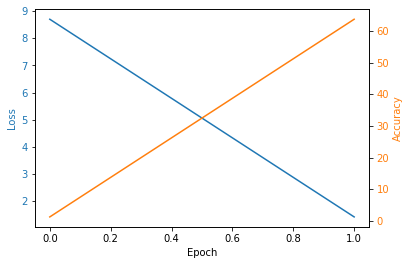

loss: 2.164541  [    0/25000] epoch: 2
loss: 1.873726  [ 3200/25000] epoch: 2
loss: 1.766729  [ 6400/25000] epoch: 2
loss: 1.876548  [ 9600/25000] epoch: 2
loss: 1.819521  [12800/25000] epoch: 2
loss: 1.002085  [16000/25000] epoch: 2
loss: 1.090721  [19200/25000] epoch: 2
loss: 0.950761  [22400/25000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 65.7%, Avg loss: 1.306785 



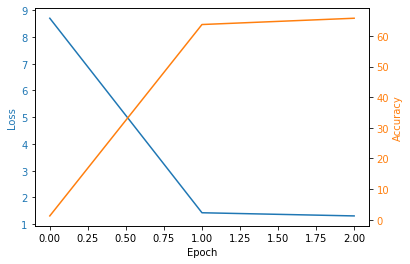

loss: 0.730516  [    0/25000] epoch: 3
loss: 1.369503  [ 3200/25000] epoch: 3
loss: 1.240750  [ 6400/25000] epoch: 3
loss: 1.511617  [ 9600/25000] epoch: 3
loss: 0.708939  [12800/25000] epoch: 3
loss: 1.007903  [16000/25000] epoch: 3
loss: 0.991125  [19200/25000] epoch: 3
loss: 1.343961  [22400/25000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 70.3%, Avg loss: 1.130355 



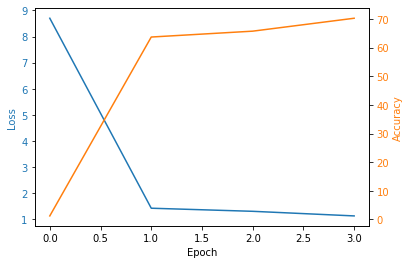

loss: 1.057142  [    0/25000] epoch: 4
loss: 0.813681  [ 3200/25000] epoch: 4
loss: 2.207693  [ 6400/25000] epoch: 4
loss: 0.983356  [ 9600/25000] epoch: 4
loss: 1.318575  [12800/25000] epoch: 4
loss: 1.183359  [16000/25000] epoch: 4
loss: 1.119129  [19200/25000] epoch: 4
loss: 1.110131  [22400/25000] epoch: 4
Epoch: 4
Test Error: 
 Accuracy: 69.4%, Avg loss: 1.172573 



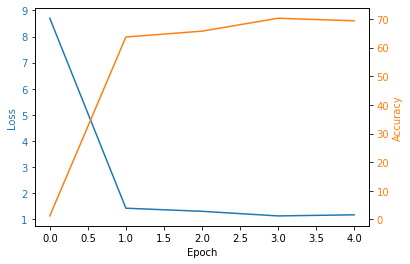

loss: 0.516847  [    0/25000] epoch: 5
loss: 0.225302  [ 3200/25000] epoch: 5
loss: 0.951755  [ 6400/25000] epoch: 5
loss: 0.582889  [ 9600/25000] epoch: 5
loss: 0.963951  [12800/25000] epoch: 5
loss: 1.595458  [16000/25000] epoch: 5
loss: 0.963502  [19200/25000] epoch: 5
loss: 0.867580  [22400/25000] epoch: 5
Epoch: 5
Test Error: 
 Accuracy: 69.8%, Avg loss: 1.165853 



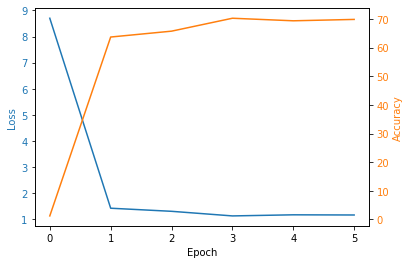

loss: 0.577411  [    0/25000] epoch: 6
loss: 0.625291  [ 3200/25000] epoch: 6
loss: 0.890052  [ 6400/25000] epoch: 6
loss: 0.526614  [ 9600/25000] epoch: 6
loss: 0.672251  [12800/25000] epoch: 6
loss: 0.951650  [16000/25000] epoch: 6
loss: 1.215568  [19200/25000] epoch: 6
loss: 1.080678  [22400/25000] epoch: 6
Epoch: 6
Test Error: 
 Accuracy: 70.4%, Avg loss: 1.160640 



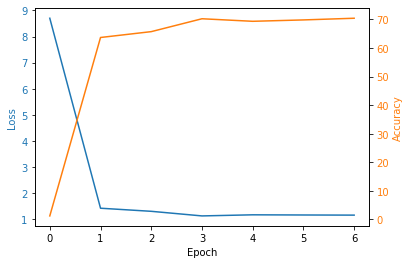

loss: 0.490380  [    0/25000] epoch: 7
loss: 0.257742  [ 3200/25000] epoch: 7
loss: 0.979579  [ 6400/25000] epoch: 7
loss: 0.090216  [ 9600/25000] epoch: 7
loss: 0.717608  [12800/25000] epoch: 7
loss: 0.569958  [16000/25000] epoch: 7
loss: 0.214085  [19200/25000] epoch: 7
loss: 0.680346  [22400/25000] epoch: 7
Epoch: 7
Test Error: 
 Accuracy: 70.2%, Avg loss: 1.172904 



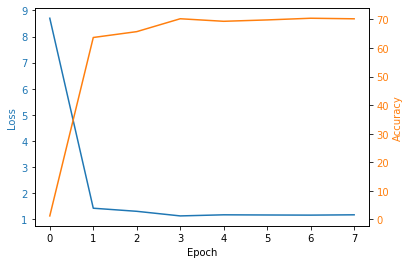

loss: 0.622491  [    0/25000] epoch: 8
loss: 0.202475  [ 3200/25000] epoch: 8
loss: 0.844776  [ 6400/25000] epoch: 8
loss: 0.721348  [ 9600/25000] epoch: 8
loss: 0.576706  [12800/25000] epoch: 8
loss: 0.943662  [16000/25000] epoch: 8
loss: 0.442018  [19200/25000] epoch: 8
loss: 0.348226  [22400/25000] epoch: 8
Epoch: 8
Test Error: 
 Accuracy: 70.9%, Avg loss: 1.172213 



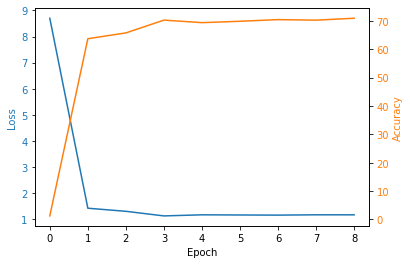

loss: 0.424085  [    0/25000] epoch: 9
loss: 0.427864  [ 3200/25000] epoch: 9
loss: 0.598770  [ 6400/25000] epoch: 9
loss: 0.239092  [ 9600/25000] epoch: 9
loss: 0.820479  [12800/25000] epoch: 9
loss: 0.252434  [16000/25000] epoch: 9
loss: 0.434038  [19200/25000] epoch: 9
loss: 1.142271  [22400/25000] epoch: 9
Epoch: 9
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.170330 



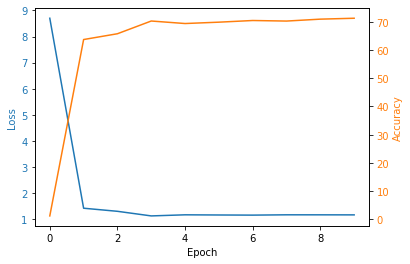

loss: 0.469566  [    0/25000] epoch: 10
loss: 0.733441  [ 3200/25000] epoch: 10
loss: 0.456028  [ 6400/25000] epoch: 10
loss: 0.437918  [ 9600/25000] epoch: 10
loss: 0.597305  [12800/25000] epoch: 10
loss: 0.587617  [16000/25000] epoch: 10
loss: 0.480752  [19200/25000] epoch: 10
loss: 0.211499  [22400/25000] epoch: 10
Epoch: 10
Test Error: 
 Accuracy: 69.9%, Avg loss: 1.260846 



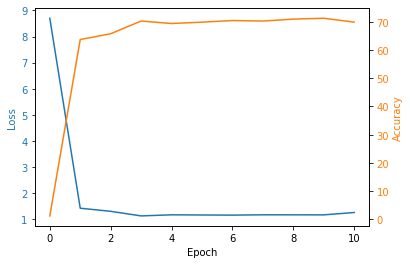

loss: 0.498671  [    0/25000] epoch: 11
loss: 0.329442  [ 3200/25000] epoch: 11
loss: 0.709096  [ 6400/25000] epoch: 11
loss: 0.815532  [ 9600/25000] epoch: 11
loss: 0.978643  [12800/25000] epoch: 11
loss: 0.165736  [16000/25000] epoch: 11
loss: 0.654135  [19200/25000] epoch: 11
loss: 1.112288  [22400/25000] epoch: 11
Epoch: 11
Test Error: 
 Accuracy: 70.1%, Avg loss: 1.232010 



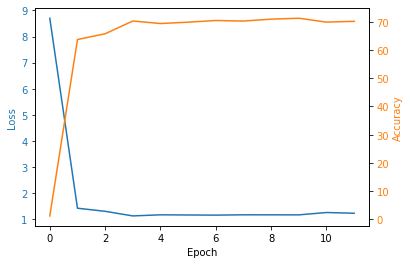

loss: 0.641963  [    0/25000] epoch: 12
loss: 0.105834  [ 3200/25000] epoch: 12
loss: 0.335624  [ 6400/25000] epoch: 12
loss: 0.241081  [ 9600/25000] epoch: 12
loss: 0.410823  [12800/25000] epoch: 12
loss: 0.189895  [16000/25000] epoch: 12
loss: 0.364945  [19200/25000] epoch: 12
loss: 0.874049  [22400/25000] epoch: 12
Epoch: 12
Test Error: 
 Accuracy: 71.0%, Avg loss: 1.248838 



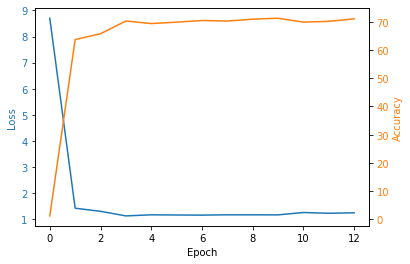

loss: 0.354384  [    0/25000] epoch: 13
loss: 0.387256  [ 3200/25000] epoch: 13
loss: 0.325700  [ 6400/25000] epoch: 13
loss: 0.604768  [ 9600/25000] epoch: 13
loss: 0.361268  [12800/25000] epoch: 13
loss: 0.164654  [16000/25000] epoch: 13
loss: 0.581407  [19200/25000] epoch: 13
loss: 1.042741  [22400/25000] epoch: 13
Epoch: 13
Test Error: 
 Accuracy: 70.6%, Avg loss: 1.267950 



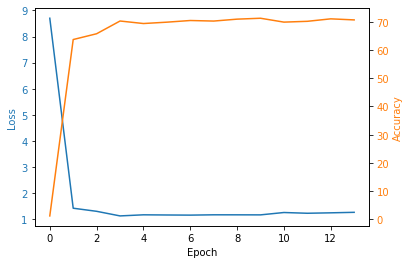

loss: 0.280076  [    0/25000] epoch: 14
loss: 0.251453  [ 3200/25000] epoch: 14
loss: 0.090890  [ 6400/25000] epoch: 14
loss: 0.432761  [ 9600/25000] epoch: 14
loss: 0.425382  [12800/25000] epoch: 14
loss: 0.564591  [16000/25000] epoch: 14
loss: 0.695517  [19200/25000] epoch: 14
loss: 0.166146  [22400/25000] epoch: 14
Epoch: 14
Test Error: 
 Accuracy: 71.3%, Avg loss: 1.277237 



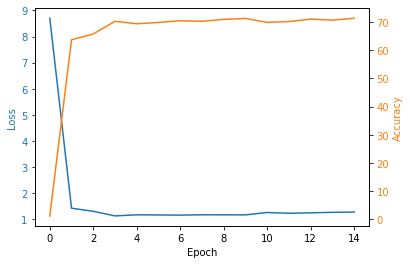

loss: 0.282980  [    0/25000] epoch: 15
loss: 0.294389  [ 3200/25000] epoch: 15
loss: 0.351389  [ 6400/25000] epoch: 15
loss: 0.211361  [ 9600/25000] epoch: 15
loss: 0.440280  [12800/25000] epoch: 15
loss: 0.411278  [16000/25000] epoch: 15
loss: 0.123568  [19200/25000] epoch: 15
loss: 1.002741  [22400/25000] epoch: 15
Epoch: 15
Test Error: 
 Accuracy: 70.5%, Avg loss: 1.298078 



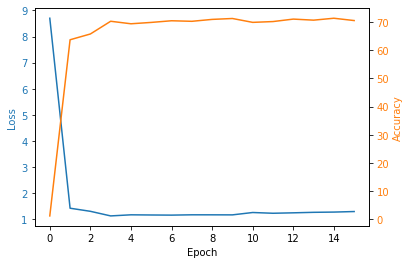

loss: 0.441167  [    0/25000] epoch: 16
loss: 0.055060  [ 3200/25000] epoch: 16
loss: 0.326835  [ 6400/25000] epoch: 16
loss: 0.249516  [ 9600/25000] epoch: 16
loss: 0.080345  [12800/25000] epoch: 16
loss: 0.055463  [16000/25000] epoch: 16
loss: 0.040196  [19200/25000] epoch: 16
loss: 0.276074  [22400/25000] epoch: 16
Epoch: 16
Test Error: 
 Accuracy: 71.1%, Avg loss: 1.292766 



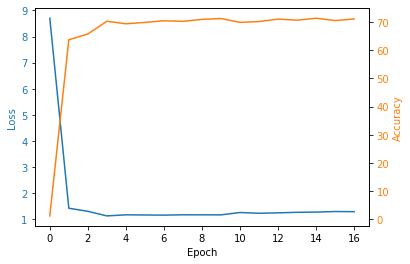

loss: 0.160175  [    0/25000] epoch: 17
loss: 0.458013  [ 3200/25000] epoch: 17
loss: 0.359522  [ 6400/25000] epoch: 17
loss: 0.336456  [ 9600/25000] epoch: 17
loss: 0.124171  [12800/25000] epoch: 17
loss: 0.227172  [16000/25000] epoch: 17
loss: 0.549488  [19200/25000] epoch: 17
loss: 0.896906  [22400/25000] epoch: 17
Epoch: 17
Test Error: 
 Accuracy: 71.3%, Avg loss: 1.300038 



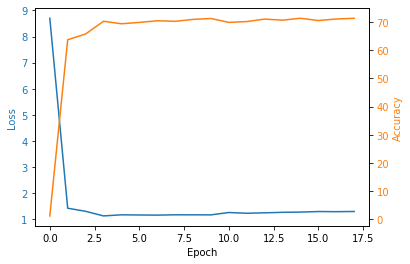

loss: 0.272629  [    0/25000] epoch: 18
loss: 0.164620  [ 3200/25000] epoch: 18
loss: 0.938082  [ 6400/25000] epoch: 18
loss: 0.315873  [ 9600/25000] epoch: 18
loss: 0.148471  [12800/25000] epoch: 18
loss: 0.051654  [16000/25000] epoch: 18
loss: 0.028164  [19200/25000] epoch: 18
loss: 0.273931  [22400/25000] epoch: 18
Epoch: 18
Test Error: 
 Accuracy: 71.6%, Avg loss: 1.315861 



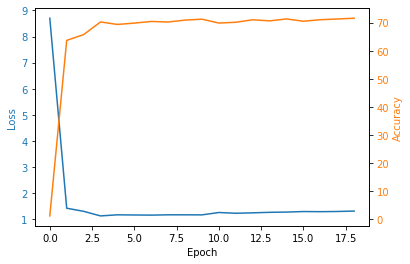

loss: 0.386024  [    0/25000] epoch: 19
loss: 0.813578  [ 3200/25000] epoch: 19
loss: 0.146896  [ 6400/25000] epoch: 19
loss: 0.122915  [ 9600/25000] epoch: 19
loss: 0.529936  [12800/25000] epoch: 19
loss: 0.038041  [16000/25000] epoch: 19
loss: 0.104545  [19200/25000] epoch: 19
loss: 0.349234  [22400/25000] epoch: 19
Epoch: 19
Test Error: 
 Accuracy: 71.5%, Avg loss: 1.344132 



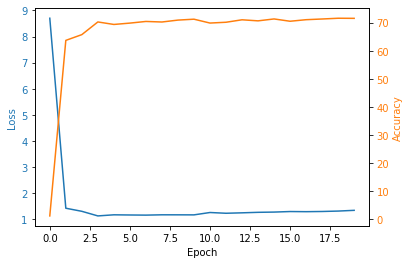

loss: 0.111359  [    0/25000] epoch: 20
loss: 0.049609  [ 3200/25000] epoch: 20
loss: 0.039880  [ 6400/25000] epoch: 20
loss: 0.262567  [ 9600/25000] epoch: 20
loss: 0.042939  [12800/25000] epoch: 20
loss: 0.240368  [16000/25000] epoch: 20
loss: 0.093675  [19200/25000] epoch: 20
loss: 0.400491  [22400/25000] epoch: 20
Epoch: 20
Test Error: 
 Accuracy: 71.9%, Avg loss: 1.325160 



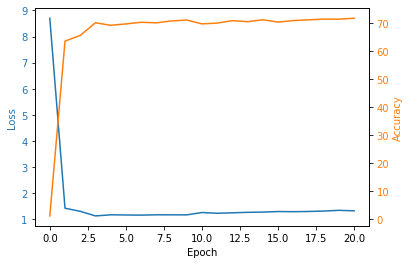

loss: 0.030897  [    0/25000] epoch: 21
loss: 0.118125  [ 3200/25000] epoch: 21
loss: 0.053192  [ 6400/25000] epoch: 21
loss: 0.099782  [ 9600/25000] epoch: 21
loss: 0.096533  [12800/25000] epoch: 21
loss: 0.240330  [16000/25000] epoch: 21
loss: 0.275972  [19200/25000] epoch: 21
loss: 0.054791  [22400/25000] epoch: 21
Epoch: 21
Test Error: 
 Accuracy: 71.3%, Avg loss: 1.352405 



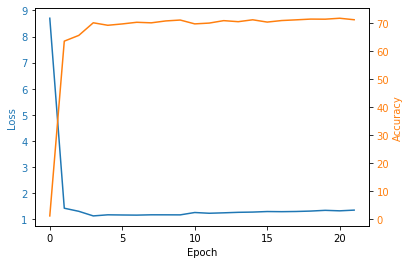

loss: 0.010191  [    0/25000] epoch: 22
loss: 0.039622  [ 3200/25000] epoch: 22
loss: 0.117398  [ 6400/25000] epoch: 22
loss: 0.064832  [ 9600/25000] epoch: 22
loss: 0.488117  [12800/25000] epoch: 22
loss: 0.200964  [16000/25000] epoch: 22
loss: 0.117870  [19200/25000] epoch: 22
loss: 0.158964  [22400/25000] epoch: 22
Epoch: 22
Test Error: 
 Accuracy: 71.7%, Avg loss: 1.326732 



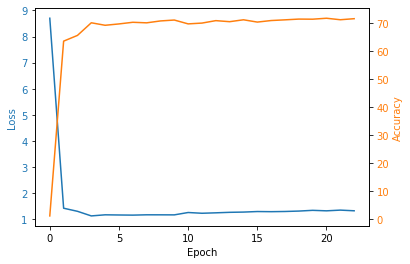

loss: 0.089494  [    0/25000] epoch: 23
loss: 0.207226  [ 3200/25000] epoch: 23
loss: 0.374029  [ 6400/25000] epoch: 23
loss: 0.013307  [ 9600/25000] epoch: 23
loss: 0.392397  [12800/25000] epoch: 23
loss: 0.144728  [16000/25000] epoch: 23
loss: 0.054970  [19200/25000] epoch: 23
loss: 0.337178  [22400/25000] epoch: 23
Epoch: 23
Test Error: 
 Accuracy: 71.0%, Avg loss: 1.374073 



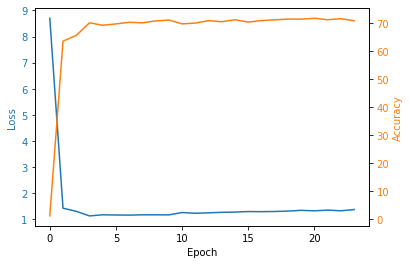

loss: 0.157915  [    0/25000] epoch: 24
loss: 0.013063  [ 3200/25000] epoch: 24
loss: 0.436750  [ 6400/25000] epoch: 24
loss: 0.227991  [ 9600/25000] epoch: 24
loss: 0.045219  [12800/25000] epoch: 24
loss: 0.135281  [16000/25000] epoch: 24
loss: 0.321447  [19200/25000] epoch: 24
loss: 0.031043  [22400/25000] epoch: 24
Epoch: 24
Test Error: 
 Accuracy: 71.0%, Avg loss: 1.373676 



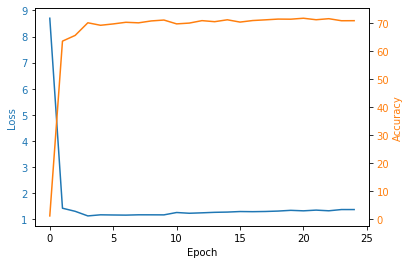

loss: 0.040442  [    0/25000] epoch: 25
loss: 0.608177  [ 3200/25000] epoch: 25
loss: 0.009770  [ 6400/25000] epoch: 25
loss: 0.009924  [ 9600/25000] epoch: 25
loss: 0.159881  [12800/25000] epoch: 25
loss: 0.153834  [16000/25000] epoch: 25
loss: 0.067477  [19200/25000] epoch: 25
loss: 0.132596  [22400/25000] epoch: 25
Epoch: 25
Test Error: 
 Accuracy: 72.7%, Avg loss: 1.338560 



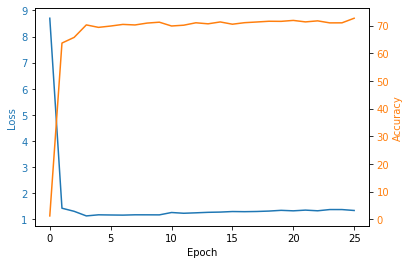

loss: 0.171903  [    0/25000] epoch: 26
loss: 0.344210  [ 3200/25000] epoch: 26
loss: 0.201563  [ 6400/25000] epoch: 26
loss: 0.187759  [ 9600/25000] epoch: 26
loss: 0.080094  [12800/25000] epoch: 26
loss: 0.091236  [16000/25000] epoch: 26
loss: 0.004893  [19200/25000] epoch: 26
loss: 0.061350  [22400/25000] epoch: 26
Epoch: 26
Test Error: 
 Accuracy: 72.1%, Avg loss: 1.391547 



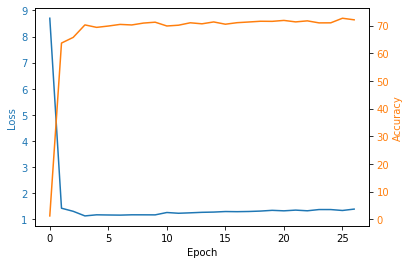

loss: 0.458967  [    0/25000] epoch: 27
loss: 0.022578  [ 3200/25000] epoch: 27
loss: 0.638608  [ 6400/25000] epoch: 27
loss: 0.276812  [ 9600/25000] epoch: 27
loss: 0.016210  [12800/25000] epoch: 27
loss: 0.059041  [16000/25000] epoch: 27
loss: 0.248933  [19200/25000] epoch: 27
loss: 0.272881  [22400/25000] epoch: 27
Epoch: 27
Test Error: 
 Accuracy: 71.6%, Avg loss: 1.386973 



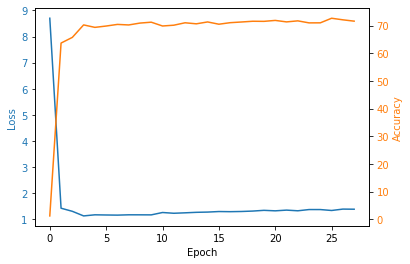

loss: 0.203014  [    0/25000] epoch: 28
loss: 0.069678  [ 3200/25000] epoch: 28
loss: 0.031213  [ 6400/25000] epoch: 28
loss: 0.085559  [ 9600/25000] epoch: 28
loss: 0.273009  [12800/25000] epoch: 28
loss: 0.162324  [16000/25000] epoch: 28
loss: 0.472941  [19200/25000] epoch: 28
loss: 0.134982  [22400/25000] epoch: 28
Epoch: 28
Test Error: 
 Accuracy: 71.3%, Avg loss: 1.443437 



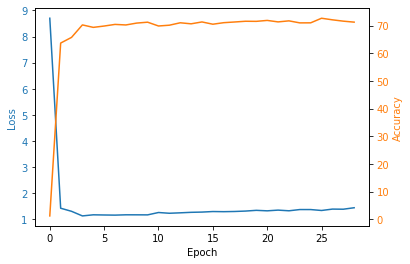

loss: 0.059275  [    0/25000] epoch: 29
loss: 0.053690  [ 3200/25000] epoch: 29
loss: 0.275917  [ 6400/25000] epoch: 29
loss: 0.075466  [ 9600/25000] epoch: 29
loss: 0.018831  [12800/25000] epoch: 29
loss: 0.032208  [16000/25000] epoch: 29
loss: 0.074727  [19200/25000] epoch: 29
loss: 0.142629  [22400/25000] epoch: 29
Epoch: 29
Test Error: 
 Accuracy: 72.1%, Avg loss: 1.392911 



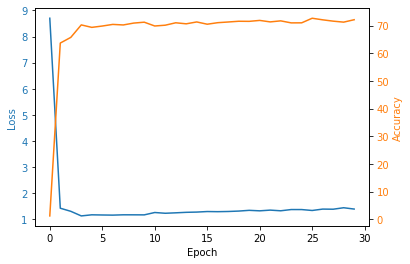

loss: 0.101491  [    0/25000] epoch: 30
loss: 0.141600  [ 3200/25000] epoch: 30
loss: 0.073086  [ 6400/25000] epoch: 30
loss: 0.061383  [ 9600/25000] epoch: 30
loss: 0.004465  [12800/25000] epoch: 30
loss: 0.010870  [16000/25000] epoch: 30
loss: 0.230302  [19200/25000] epoch: 30
loss: 0.075575  [22400/25000] epoch: 30
Epoch: 30
Test Error: 
 Accuracy: 70.8%, Avg loss: 1.498807 



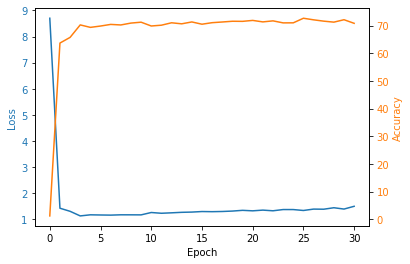

loss: 0.118019  [    0/25000] epoch: 31
loss: 0.123488  [ 3200/25000] epoch: 31
loss: 0.233027  [ 6400/25000] epoch: 31
loss: 0.154555  [ 9600/25000] epoch: 31
loss: 0.033891  [12800/25000] epoch: 31
loss: 0.000632  [16000/25000] epoch: 31
loss: 0.096489  [19200/25000] epoch: 31
loss: 0.302833  [22400/25000] epoch: 31
Epoch: 31
Test Error: 
 Accuracy: 71.3%, Avg loss: 1.428676 



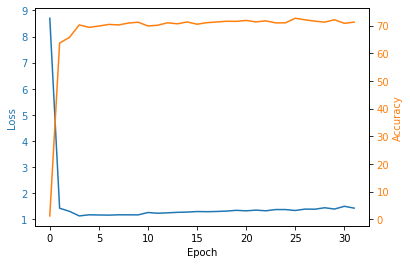

loss: 0.031332  [    0/25000] epoch: 32
loss: 0.077943  [ 3200/25000] epoch: 32
loss: 0.028757  [ 6400/25000] epoch: 32
loss: 0.099117  [ 9600/25000] epoch: 32
loss: 0.003749  [12800/25000] epoch: 32
loss: 0.044824  [16000/25000] epoch: 32
loss: 0.080159  [19200/25000] epoch: 32
loss: 0.098076  [22400/25000] epoch: 32
Epoch: 32
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.448868 



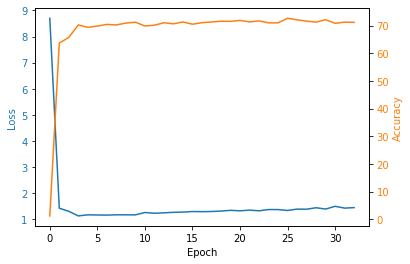

loss: 0.007700  [    0/25000] epoch: 33
loss: 0.011886  [ 3200/25000] epoch: 33
loss: 0.152794  [ 6400/25000] epoch: 33
loss: 0.070682  [ 9600/25000] epoch: 33
loss: 0.004525  [12800/25000] epoch: 33
loss: 0.049373  [16000/25000] epoch: 33
loss: 0.297322  [19200/25000] epoch: 33
loss: 0.308057  [22400/25000] epoch: 33
Epoch: 33
Test Error: 
 Accuracy: 71.5%, Avg loss: 1.470918 



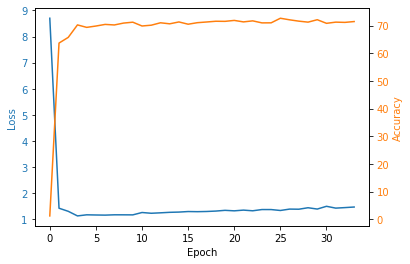

loss: 0.078077  [    0/25000] epoch: 34
loss: 0.046167  [ 3200/25000] epoch: 34
loss: 0.042317  [ 6400/25000] epoch: 34
loss: 0.020686  [ 9600/25000] epoch: 34
loss: 0.409856  [12800/25000] epoch: 34
loss: 0.036088  [16000/25000] epoch: 34
loss: 0.080686  [19200/25000] epoch: 34
loss: 0.081265  [22400/25000] epoch: 34
Epoch: 34
Test Error: 
 Accuracy: 71.3%, Avg loss: 1.443490 



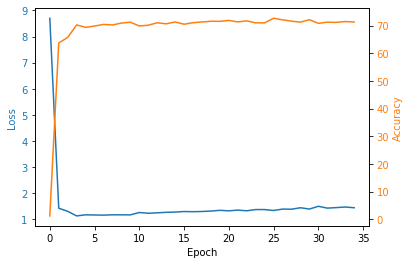

loss: 0.135422  [    0/25000] epoch: 35
loss: 0.136779  [ 3200/25000] epoch: 35
loss: 0.148910  [ 6400/25000] epoch: 35
loss: 0.056115  [ 9600/25000] epoch: 35
loss: 0.302582  [12800/25000] epoch: 35
loss: 0.012660  [16000/25000] epoch: 35
loss: 0.030279  [19200/25000] epoch: 35
loss: 0.042851  [22400/25000] epoch: 35
Epoch: 35
Test Error: 
 Accuracy: 70.6%, Avg loss: 1.486741 



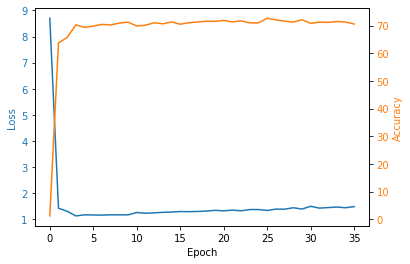

loss: 0.046370  [    0/25000] epoch: 36
loss: 0.472807  [ 3200/25000] epoch: 36
loss: 0.010277  [ 6400/25000] epoch: 36
loss: 0.171720  [ 9600/25000] epoch: 36
loss: 0.085762  [12800/25000] epoch: 36
loss: 0.102332  [16000/25000] epoch: 36
loss: 0.068491  [19200/25000] epoch: 36
loss: 0.260345  [22400/25000] epoch: 36
Epoch: 36
Test Error: 
 Accuracy: 71.0%, Avg loss: 1.481541 



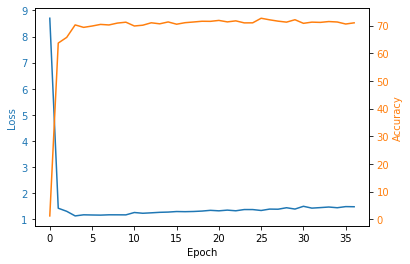

loss: 0.007163  [    0/25000] epoch: 37
loss: 0.173034  [ 3200/25000] epoch: 37
loss: 0.387655  [ 6400/25000] epoch: 37
loss: 0.155174  [ 9600/25000] epoch: 37
loss: 0.258746  [12800/25000] epoch: 37
loss: 0.000863  [16000/25000] epoch: 37
loss: 0.099442  [19200/25000] epoch: 37
loss: 0.097297  [22400/25000] epoch: 37
Epoch: 37
Test Error: 
 Accuracy: 71.5%, Avg loss: 1.480066 



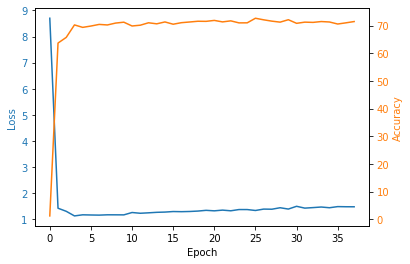

loss: 0.019635  [    0/25000] epoch: 38
loss: 0.080272  [ 3200/25000] epoch: 38
loss: 0.065109  [ 6400/25000] epoch: 38
loss: 0.034598  [ 9600/25000] epoch: 38
loss: 0.101761  [12800/25000] epoch: 38
loss: 0.113776  [16000/25000] epoch: 38
loss: 0.017791  [19200/25000] epoch: 38
loss: 0.054704  [22400/25000] epoch: 38
Epoch: 38
Test Error: 
 Accuracy: 70.9%, Avg loss: 1.512444 



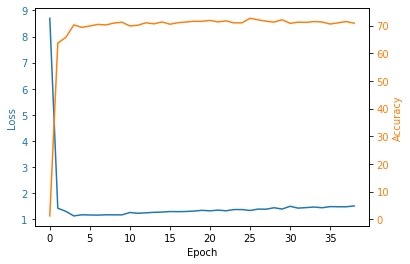

loss: 0.038798  [    0/25000] epoch: 39
loss: 0.056500  [ 3200/25000] epoch: 39
loss: 0.105869  [ 6400/25000] epoch: 39
loss: 0.004988  [ 9600/25000] epoch: 39
loss: 0.132947  [12800/25000] epoch: 39
loss: 0.256345  [16000/25000] epoch: 39
loss: 0.068432  [19200/25000] epoch: 39
loss: 0.018916  [22400/25000] epoch: 39
Epoch: 39
Test Error: 
 Accuracy: 71.4%, Avg loss: 1.508588 



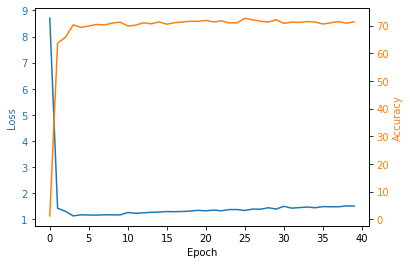

loss: 0.354796  [    0/25000] epoch: 40
loss: 0.014449  [ 3200/25000] epoch: 40
loss: 0.003161  [ 6400/25000] epoch: 40
loss: 0.116918  [ 9600/25000] epoch: 40
loss: 0.020166  [12800/25000] epoch: 40
loss: 0.010611  [16000/25000] epoch: 40
loss: 0.019996  [19200/25000] epoch: 40
loss: 0.040031  [22400/25000] epoch: 40
Epoch: 40
Test Error: 
 Accuracy: 70.9%, Avg loss: 1.532847 



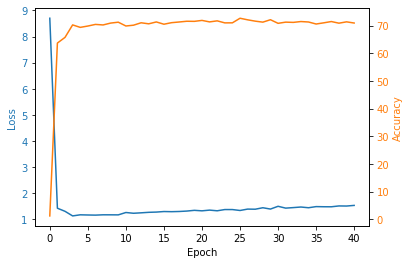

In [26]:
stats = train_loop(trainloader, beit, criterion, optimizer)

In [27]:
df_stats = pd.DataFrame(stats)
df_stats.to_csv("../../stats.csv")

In [13]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

beit.load_state_dict(torch.load("../../other_beit_optimal.pth"))
beit.to(device)

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (interme

In [18]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = beit(X)["logits"].argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|████████████████████████████████████████| 479/479 [02:40<00:00,  2.98it/s]


In [19]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,15
1,test_10.jpg,45
2,test_100.jpg,75
3,test_1000.jpg,29
4,test_1001.jpg,18


In [20]:
test_df.to_csv("../../submission_beit_other.csv", index=False)